In [1]:
import os, getpass
from dotenv import load_dotenv 
load_dotenv(override=True)

True

In [2]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import StateGraph, END
from langchain.schema import HumanMessage
from langchain.prompts import PromptTemplate
import gradio as gr

from langchain_community.utilities import OpenWeatherMapAPIWrapper
weather = OpenWeatherMapAPIWrapper()

c:\Users\jaiva\Desktop\A_lect\GAI\projects\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OPENAI API Key: ")

   #Check for Groq API Key
if "OPENWEATHERMAP_API_KEY" not in os.environ:
    os.environ["OPENWEATHERMAP_API_KEY"] = getpass.getpass("WEATHER API Key: ")


if "AMADEUS_CLIENT_ID" not in os.environ:
    os.environ["AMADEUS_CLIENT_ID"] = getpass.getpass("WEATHER API Key: ")
    
if "AMADEUS_CLIENT_SECRET" not in os.environ:
    os.environ["AMADEUS_CLIENT_SECRET"] = getpass.getpass("WEATHER API Key: ")    

In [5]:
from langchain.chat_models import init_chat_model

llm = init_chat_model(model="gpt-4o-mini", model_provider="openai")

In [ ]:
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage

llm = ChatOllama(
    model="llama3.1:8b",
    base_url="http://localhost:11434"  # 👈 this sets your Ollama server URL
)

In [6]:
from pydantic import BaseModel
from typing import Optional, Annotated
from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState

class ReviewState(TypedDict, total=False):
    user_message: Annotated[str, "The original travel location input from the user"]
    planner_agent_feedback: Annotated[list[BaseMessage], "Feedback from the itinerary planner agent"]
    budget_agent_feedback: Annotated[list[BaseMessage], "Feedback from the budget agent"] 
   


In [ ]:
weather.run("Bali, Indonesia")

In [21]:
from langchain.tools import Tool


def return_weather_data(user_inp: str) -> list:
    """Find weather of the Destination's provided
    Args:
        user_inp: Destination's user wants to visit
    """
    data=[]
    list_cities = user_inp.strip().split(',')
    print(list_cities)

    for city in list_cities:
        data.append(weather.run(city))
    #print(data)
 
    return data # just return raw weather string


tools_P =  [Tool.from_function(
    name="return_weather_data",  # Name that LLM returns
    func=return_weather_data,
    description="Use this tool to get the current weather for a list of cities. " \
    "The input must be a single or Multiple comma separated city name."
)]

# tools_P = [return_weather_data]

# llm_with_weather = llm.bind_tools(tools_P)

# output = llm_with_weather.invoke([HumanMessage(content="Trip to Bali")])
# output


In [24]:
from langchain.agents import create_react_agent, AgentExecutor
from langchain.prompts import PromptTemplate

prompt_p = PromptTemplate.from_template(
"""You are an Expert Itinerary Planning Agent. Your goal is to create a detailed travel itinerary for 1 week Max Dont give beyond that and should be less than 1800 characters.
You have access to the following tools:{tools}
To use a tool, follow this strict format:
Thought: Your reasoning process, leading to a tool call or final answer.
Action: the name of the tool to call, ONLY one of [{tool_names}]
Action Input: the input parameters for the tool (e.g., Mumbai,London,Paris)
Observation: the result received from the tool

Once you have gathered all necessary information (like weather for all cities) and are ready to present the itinerary, you MUST use the following format for your final response:
Thought: I have gathered all necessary information and I am now ready to present the detailed itinerary.
Final Answer: [Your complete and detailed travel itinerary, incorporating all weather data and logical planning.]

---
**Your Planning Steps:**
1.  **Understand the Request & Identify Cities (Mental Step):** Read the user's question and determine the primary cities for the itinerary (e.g., "Mumbai" and "London" from "Mumbai to London"). This is a thinking step; do NOT use an `Action:` for this.
2.  **Get Weather Data for Each City (Tool Use):** For EACH identified city, use the `return_weather_data` tool. Call it by passing all city names.
    * **Example Action for weather:** `Action: return_weather_data\nAction Input: Mumbai,London,Paris`
3.  **Synthesize Information & Plan Itinerary (Mental Step):** Once you have the weather data for all cities, use your expertise to synthesize this information and logically plan the itinerary. This is an internal reasoning step; do NOT use an `Action:` for this.
4.  **Provide Final Answer (Output Format):** Present the complete itinerary using the `Final Answer` format described above.
---

**Important Constraint:**
- The user mentioned a budget, but you should IGNORE it as per your instructions.
Begin!
Question:{user_message}
{agent_scratchpad}
"""

)

# Step 5: Create agent and executor
agent = create_react_agent(llm=llm, tools=tools_P, prompt=prompt_p)
agent_exec = AgentExecutor(agent=agent, tools=tools_P, verbose=True,handle_parsing_errors=True,max_iterations=4)


In [25]:
# LangChain's create_react_agent() requires these 3 input variables to be present in your PromptTemplate:

# {tools} – A description of each tool

# {tool_names} – A comma-separated list of tool names

# {agent_scratchpad} – Internal scratchpad for ReAct steps


output = agent_exec.invoke({"user_message":"I want a vacation under $10000 for Mumbai to London"})



> Entering new AgentExecutor chain...
Thought: I need to create a 1-week itinerary for a trip from Mumbai to London. First, I will gather the current weather data for both cities to ensure the activities are suitable for the conditions.

Action: return_weather_data  
Action Input: Mumbai, London  
['Mumbai', ' London']
['In Mumbai, the current weather is as follows:\nDetailed status: overcast clouds\nWind speed: 4.44 m/s, direction: 251°\nHumidity: 80%\nTemperature: \n  - Current: 27.46°C\n  - High: 27.46°C\n  - Low: 27.46°C\n  - Feels like: 30.79°C\nRain: {}\nHeat index: None\nCloud cover: 100%', 'In  London, the current weather is as follows:\nDetailed status: overcast clouds\nWind speed: 3.88 m/s, direction: 161°\nHumidity: 59%\nTemperature: \n  - Current: 21.6°C\n  - High: 21.6°C\n  - Low: 21.6°C\n  - Feels like: 21.36°C\nRain: {}\nHeat index: None\nCloud cover: 100%']I have gathered all necessary information regarding the weather in Mumbai and London. Now, I can craft a detailed

In [44]:
from langchain.prompts import PromptTemplate
from langchain_core.messages import HumanMessage,SystemMessage

def planner_agent(state: ReviewState) -> ReviewState:

    print("STATE RECEIVED:", state)

    user_message = state.get("user_message", "testingggg")
    if not user_message:
        raise ValueError("Missing 'user_message' in state.")

    # The prompt expects a dict with only 'user_message'
    
    agent_resp = agent_exec.invoke({"user_message":user_message})
    
    print(agent_resp)
    # Return updated state
    return {
        "planner_agent_feedback": agent_resp["output"]
    }

In [60]:

from amadeus import Client, ResponseError

amadeus_client = Client(
    client_id=os.environ["AMADEUS_CLIENT_ID"],
    client_secret=os.environ["AMADEUS_CLIENT_SECRET"]
)


from langchain.tools import Tool

def return_search_flights_tool(flight_information: str) -> list:
    """Search flights using input

    Always use the format for (BOM,DPS,2025-08-01,2025-08-07).
    No Other Input should be added besides the four input with specific format
    """
    print("flight_information raw:", repr(flight_information))
    try:
        # Strip and split
        query_with_IATA_airport_codes_src, query_with_IATA_airport_codes_des, departure_date,return_date = map(str.strip, flight_information.strip().split(","))

        print(query_with_IATA_airport_codes_src)
        print(query_with_IATA_airport_codes_des)
        print(departure_date)

        response1 = amadeus_client.shopping.flight_offers_search.get(
            originLocationCode=query_with_IATA_airport_codes_src.upper(),
            destinationLocationCode=query_with_IATA_airport_codes_des.upper(),
            departureDate=departure_date,
            adults=1
        )

        response2 = amadeus_client.shopping.flight_offers_search.get(
            originLocationCode=query_with_IATA_airport_codes_des.upper(),
            destinationLocationCode=query_with_IATA_airport_codes_src.upper(),
            departureDate=return_date,
            adults=1
        )

        # print(response1.data[:3])
        # print(response2.data[:3])

        return [response1.data[:3],response2.data[:3]] 
    except ResponseError as e:
        return [f"Amadeus API Error: {e} - {e.response.body}"]
    except Exception as e:
        return [f"Invalid input. Use format: 'BOM,DPS,2025-08-01,2025-08-07'. Error: {str(e)}"]


tools_B =  [Tool.from_function(
    name="return_search_flights_tool",  # Name that LLM returns
    func=return_search_flights_tool,
    description=  """  
    Use this tool to search for flight offers.
    The input to this tool must be a single string, containing three comma-separated values:
    Example Input: BOM,DPS,2025-08-01,2025-08-07
    No Other Input should be added besides the three input with specific format
    """
)]



#

# llm_with_flight = llm.bind_tools(tools_B)

# output = llm_with_flight.invoke([HumanMessage(content="Trip form Mumbai to Bali under 10000 budget")])
# output

In [ ]:
return_search_flights_tool("BOM,DPS,2025-08-01")

In [105]:


prompt_b = PromptTemplate.from_template(
 """ You are an expert **Budget Agent**. Your task is to select cost-effective flights for a trip using the destination and travel duration provided by the Planner Agent.

You have access to the following tools:{tools}
To use a tool, follow this strict format:
Thought: Your reasoning process, leading to a tool call or final answer.
Action: The name of the tool to call, ONLY one of [{tool_names}]
Action Input: source,destination,departure_date (e.g., BOM,DPS,2025-08-01,2025-08-07)
Observation: the result received from the tool will contain round trip information

Once all required information has been gathered (including best flight details and estimated costs per itinerary item), respond using the exact format below.
Thought: I have gathered all necessary information and I am now ready to present the detailed itinerary.  
Final Answer:[Planner_Message - Include the full original planner itinerary message with each day clearly labeled. For each day, estimate costs for accommodation, food, tickets, transport, etc.
Then include:
**Estimated Non-Flight Costs Summary (₹):**

| Day | Activity                          | Estimated ₹ |
|-----|-----------------------------------|-------------|
| 1   | Hotel stay                        | X,XXX       |
| 2   | Food + Sightseeing                | X,XXX       |
| ... | ...                               | ...         |
|     | **Total (non-flight):**          | **₹XX,XXX** |

---
**Flight Details:**

1. **Outbound Flight**  
   - **Date:** [Date]  
   - **From:** [Origin] at [Time]  
   - **To:** [Destination] at [Time]  
   - **Stopover:** [Stop if any]  
   - **Duration:** [Xh Xm]  
   - **Fare:** [€Amount ≈ ₹Amount]

2. **Return Flight**  
   - **Date:** [Date]  
   - **From:** [Origin] at [Time]  
   - **To:** [Destination] at [Time]  
   - **Stopover:** [Stop if any]  
   - **Duration:** [Xh Xm]  
   - **Fare:** [€Amount ≈ ₹Amount]

**Total Flight Cost:** €XXX.XX ≈ ₹XX,XXX
---
**💰 Final Cost Estimate:**
- **Flights:** ₹XX,XXX  
- **Daily itinerary (hotel, food, activity):** ₹XX,XXX  
- **Total Estimated Budget:** ₹XX,XXX  
Final Budget Details: in_budget or out_of_budget
]  

---
**Your Planning Steps:**
1.  **Understand the Request & Identify Cities (Mental Step):** Read the user's question and determine the primary cities for the itinerary (e.g., "Mumbai" and "London" from "Mumbai to London"). This is a thinking step; do NOT use an `Action:` for this.
2.  **Get Flight Data for the Trip (Tool Use):** For identified route, use the `return_search_flights_tool` tool. Call it by passing the source,destination,departure date and return date.
    * **Example Action for flight details:** `Action: return_search_flights_tool\nAction Input: BOM,DPS,2025-08-01,2025-08-07`
3.  **Synthesize Information & Plan Itinerary (Mental Step):** Once you have the Flight data for route, use your expertise to synthesize this information and logically plan the itinerary. This is an internal reasoning step; do NOT use an `Action:` for this.
4.  **Provide Final Answer (Output Format):** Present the complete itinerary using the `Final Answer` format described above.
---
Planner_Message:{planner_agent_feedback}
Begin!
{agent_scratchpad}
"""

)

agent_B = create_react_agent(llm=llm, tools=tools_B, prompt=prompt_b)
agent_exec_b = AgentExecutor(agent=agent_B, tools=tools_B, verbose=True,handle_parsing_errors=True)


In [106]:
from langchain.prompts import PromptTemplate
from langchain_core.messages import HumanMessage,AIMessage

def budget_agent(state: ReviewState) -> ReviewState:
    

    # Define the budget planner prompt
   

    msg_planner_agent_feedback = state.get("planner_agent_feedback","")

    print(msg_planner_agent_feedback)
    # Call the LLM with flight tool
    agent_resp = agent_exec_b.invoke({"planner_agent_feedback": str(msg_planner_agent_feedback)})
    print(agent_resp)

    # Update state with feedback
    #state["budget_agent_feedback"] = output

    return {"budget_agent_feedback":agent_resp["output"]}


In [ ]:
#agent_exec_b.invoke({"planner_agent_feedback":"I want a vacation under $10000 for Mumbai to Bali for date 1st august 2025?"})

In [107]:
from typing import Literal

def budget_router(state: ReviewState) -> Literal["Planner_Agent", "Default"]:
    # Inspect state to decide

    print(state["user_message"])
    print(state["planner_agent_feedback"])
    print(state["budget_agent_feedback"])

    latest_message = state["budget_agent_feedback"]

    if "in_budget" in latest_message.lower():
        print("Routed to Default - END via message content")
        return "Default"

   
    print("Routed to Planner_Agent")
        
    return "Planner_Agent"

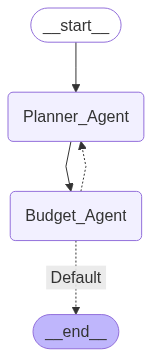

In [108]:
from langgraph.graph import START,END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

graph_builder = StateGraph(ReviewState)

# Add only actual state-changing nodes
graph_builder.add_node("Planner_Agent", planner_agent)
graph_builder.add_node("Budget_Agent", budget_agent)


# Start at Planner_Agent
graph_builder.add_edge(START, "Planner_Agent")

graph_builder.add_edge("Planner_Agent", "Budget_Agent")


# After Budget_Agent, route using budget_router
graph_builder.add_conditional_edges(
    "Budget_Agent",
    budget_router,
    {
        "Planner_Agent": "Planner_Agent",
        "Default": END
    }
)


# Compile and visualize
graph = graph_builder.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [109]:
result = graph.invoke({"user_message": "I want a vacation under budget of $10000 for Mumbai to London"})

for key, value in result.items():
    print(f"\n🔹 {key.upper()}:\n{value}")

STATE RECEIVED: {'user_message': 'I want a vacation under budget of $10000 for Mumbai to London'}


> Entering new AgentExecutor chain...
Thought: I need to prepare a detailed 1-week itinerary for a trip from Mumbai to London. First, I will gather weather information for both cities to ensure convenient planning. 

Action: return_weather_data  
Action Input: Mumbai, London  
['Mumbai', ' London']
['In Mumbai, the current weather is as follows:\nDetailed status: overcast clouds\nWind speed: 4.08 m/s, direction: 252°\nHumidity: 80%\nTemperature: \n  - Current: 27.54°C\n  - High: 27.54°C\n  - Low: 27.54°C\n  - Feels like: 30.98°C\nRain: {}\nHeat index: None\nCloud cover: 100%', 'In  London, the current weather is as follows:\nDetailed status: overcast clouds\nWind speed: 3.51 m/s, direction: 163°\nHumidity: 66%\nTemperature: \n  - Current: 20.72°C\n  - High: 20.72°C\n  - Low: 20.72°C\n  - Feels like: 20.57°C\nRain: {}\nHeat index: None\nCloud cover: 100%']I have gathered the necessary wea

In [86]:
# --- Gradio Interface ---
def review(input_str: str) -> str:
    initial_state: ReviewState = {"user_message": input_str}
    final_state = graph.invoke(initial_state)
    return final_state['budget_agent_feedback']

iface = gr.Interface(
    fn=review,
    inputs=gr.Textbox(lines=10, label="Enter Trip Details"),
    outputs=gr.Textbox(lines=10, label="Planned Output"),
    title="Multi-Agent Trip Assistant",
    description="Submit Your trip request and get details  and plan from an LLM-powered agent pipeline."
)

In [ ]:
if __name__ == "__main__":
    iface.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


STATE RECEIVED: {'user_message': 'A trip for jaipur to London under budget of Rs200000'}


> Entering new AgentExecutor chain...
Thought: I need to create a detailed one-week itinerary for a trip from Jaipur to London. First, I will check the current weather in both cities to ensure the plan is suitable for the visitor's comfort.

Action: return_weather_data  
Action Input: Jaipur, London  
['Jaipur', ' London']
['In Jaipur, the current weather is as follows:\nDetailed status: overcast clouds\nWind speed: 9.02 m/s, direction: 167°\nHumidity: 94%\nTemperature: \n  - Current: 24.44°C\n  - High: 24.44°C\n  - Low: 24.44°C\n  - Feels like: 25.39°C\nRain: {}\nHeat index: None\nCloud cover: 100%', 'In  London, the current weather is as follows:\nDetailed status: overcast clouds\nWind speed: 3.51 m/s, direction: 163°\nHumidity: 65%\nTemperature: \n  - Current: 20.85°C\n  - High: 20.85°C\n  - Low: 20.85°C\n  - Feels like: 20.69°C\nRain: {}\nHeat index: None\nCloud cover: 100%']I have gathered t